# Juggling with multiparametric and hierarchical models

This is the code is adapted from [Bayesian Analysis with Python](https://github.com/aloctavodia/BAP).


In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

import warnings
warnings.filterwarnings("ignore")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


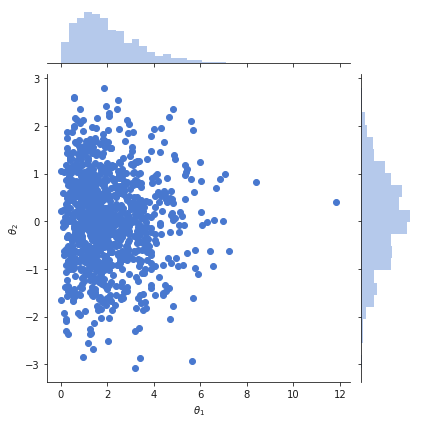

In [2]:
np.random.seed(123)
x = np.random.gamma(2, 1, 1000)
y = np.random.normal(0, 1, 1000)
data = pd.DataFrame(data=np.array([x, y]).T, columns=['$\\theta_1$', '$\\theta_2$'])
sns.jointplot(x='$\\theta_1$', y='$\\theta_2$', data=data, stat_func=None);


# Gaussian inferences

In [3]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])


# remove outliers using the interquartile rule
quant = np.percentile(data, [25, 75])
iqr = quant[1] - quant[0]
upper_b = quant[1] + iqr * 1.5
lower_b = quant[0] - iqr * 1.5
clean_data = data[(data > lower_b) & (data < upper_b)]

#print(np.mean(data), np.std(data))
#print(np.mean(clean_data), np.std(clean_data))

Text(0.5,0,'$x$')

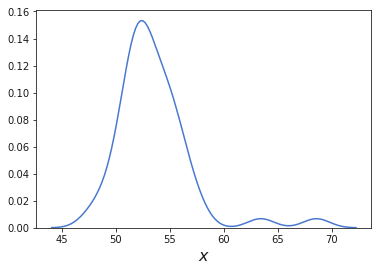

In [4]:
sns.kdeplot(data)
plt.xlabel('$x$', fontsize=16)


In [5]:
with pm.Model() as model_g:
    mu = pm.Uniform('mu', lower=40, upper=70)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    trace_g = pm.sample(1100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1600/1600 [00:01<00:00, 1351.72it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd29f2a4630>,
      dtype=object)

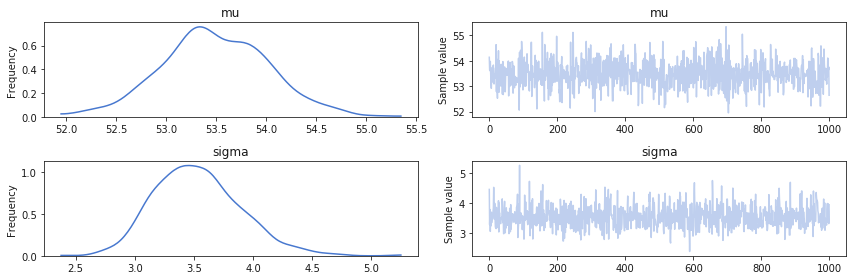

In [6]:
chain_g = trace_g[100:]
pm.traceplot(chain_g)


In [7]:
pm.df_summary(chain_g)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,53.49,0.53,0.02,52.39,54.53
sigma,3.53,0.36,0.01,2.90,4.29


100%|██████████| 100/100 [00:00<00:00, 198.24it/s]


Text(0.5,0,'$x$')

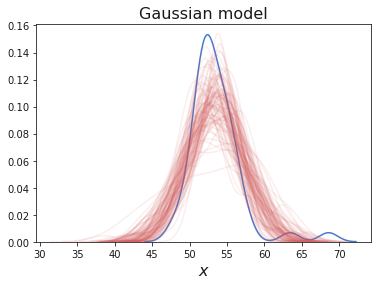

In [8]:
y_pred = pm.sample_ppc(chain_g, 100, model_g, size=len(data))
sns.kdeplot(data, color='b')
for i in y_pred['y']:
    sns.kdeplot(i, color='r', alpha=0.1)
plt.title('Gaussian model', fontsize=16)
plt.xlabel('$x$', fontsize=16)


## Gaussian Robust inferences

Now we are going to learn how to make a robust model to outliers, that is a model that do not get too much excited by outliers. For that we are going to use a Student T distribution:

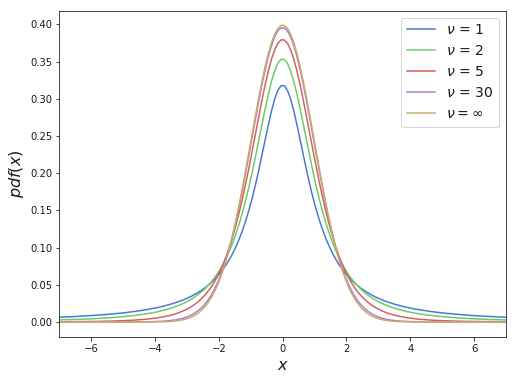

In [9]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 200)
for df in [1, 2, 5, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=r'$\nu$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label=r'$\nu = \infty$')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$pdf(x)$', fontsize=16, rotation=90)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);


In [10]:
with pm.Model() as model_t:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd=10)
    nu = pm.Exponential('nu', 1/30)
    y = pm.StudentT('y', mu=mu, sd=sigma, nu=nu, observed=data)
    trace_t = pm.sample(1100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1600/1600 [00:01<00:00, 1265.49it/s]


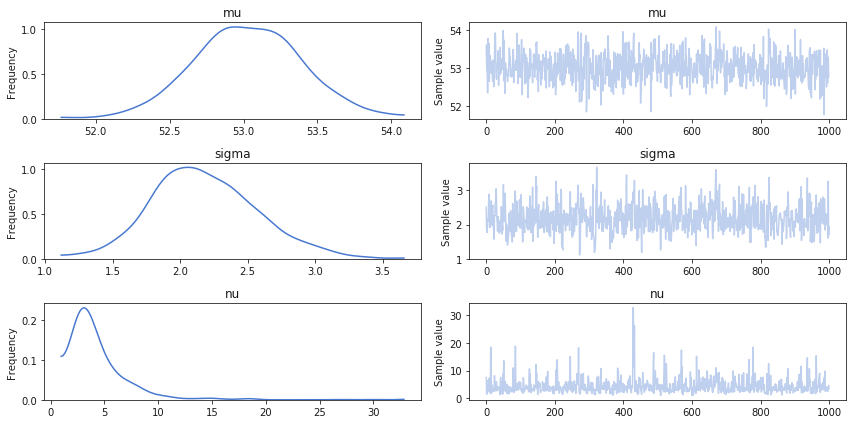

In [11]:
chain_t = trace_t[100:]
pm.traceplot(chain_t);


In [12]:
pm.df_summary(chain_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,53.03,0.36,0.01,52.28,53.70
sigma,2.19,0.39,0.02,1.47,3.02
nu,4.45,2.93,0.12,0.99,9.20


100%|██████████| 100/100 [00:00<00:00, 3338.38it/s]


Text(0.5,0,'$x$')

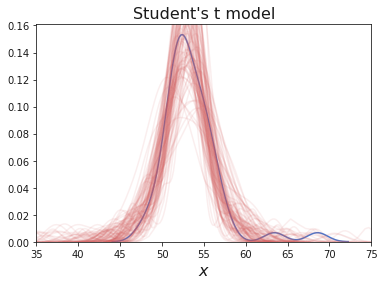

In [13]:
y_pred = pm.sample_ppc(chain_t, 100, model_t, size=len(data))
sns.kdeplot(data, c='b')
for i in y_pred['y']:
    sns.kdeplot(i, c='r', alpha=0.1)
plt.xlim(35, 75)
plt.title("Student's t model", fontsize=16)
plt.xlabel('$x$', fontsize=16)


# Tips example

In [14]:
tips = sns.load_dataset('tips')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


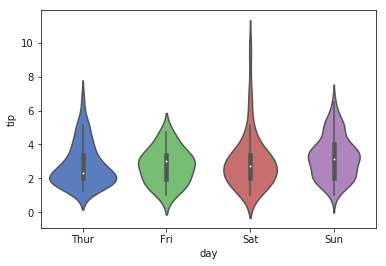

In [15]:
sns.violinplot(x='day', y='tip', data=tips);


In [16]:
y = tips['tip'].values
x = pd.Categorical(tips['day']).codes

In [17]:
with pm.Model() as comparing_groups:        
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(x)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(x)))

    y = pm.Normal('y', mu=means[x], sd=sds[x], observed=y)
    
    trace_cg = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:07<00:00, 717.38it/s]


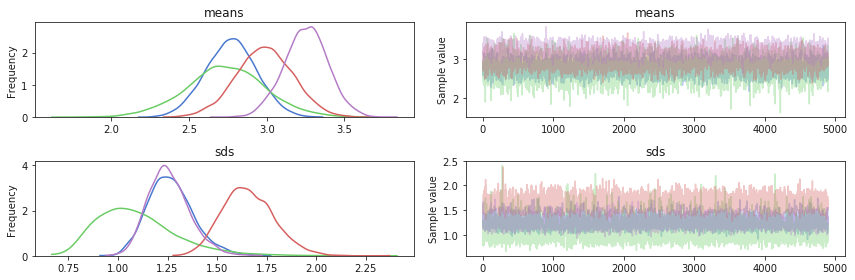

In [18]:
chain_cg = trace_cg[100::]
pm.traceplot(chain_cg);


In [19]:
pm.df_summary(chain_cg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
means__0,2.77,0.16,2.09e-03,2.45,3.09
means__1,2.74,0.26,3.54e-03,2.22,3.24
means__2,2.99,0.18,2.49e-03,2.61,3.33
means__3,3.25,0.14,2.08e-03,2.97,3.52
sds__0,1.27,0.12,1.63e-03,1.05,1.50
sds__1,1.10,0.20,3.73e-03,0.77,1.52
sds__2,1.66,0.13,1.97e-03,1.43,1.93
sds__3,1.26,0.11,1.47e-03,1.07,1.48


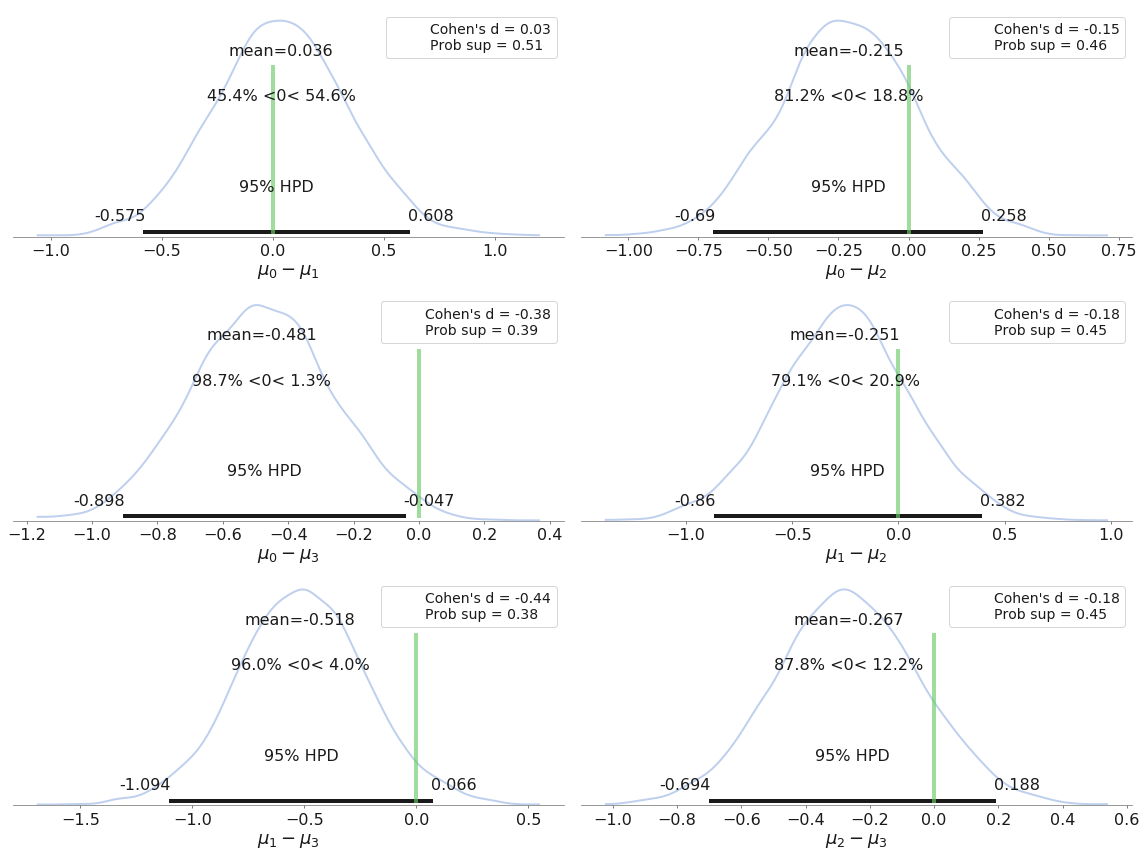

In [20]:
dist = dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(16, 12))

comparisons = [(i,j) for i in range(4) for j in range(i+1, 4)]
pos = [(k,l) for k in range(3) for l in (0, 1)]

for (i, j), (k,l) in zip(comparisons, pos):
    means_diff = chain_cg['means'][:,i]-chain_cg['means'][:,j]
    d_cohen = (means_diff / np.sqrt((chain_cg['sds'][:,i]**2 + chain_cg['sds'][:,j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
        
    pm.plot_posterior(means_diff, ref_val=0, ax=ax[k, l], kde_plot=True, lw=2)
    ax[k, l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps) ,alpha=0)
    ax[k, l].set_xlabel('$\mu_{}-\mu_{}$'.format(i, j), fontsize=18)
    ax[k,l ].legend(loc=0, fontsize=14)
plt.tight_layout()


# Hierarchical Models

In [21]:
N_samples =  [30, 30, 30]
G_samples =  [18, 18, 18] # [13, 3, 3] [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []  
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

$$\alpha \sim HalfCauchy(\beta_{\alpha})$$
$$\beta \sim HalfCauchy(\beta_{\beta})$$
$$\theta \sim Beta(\alpha, \beta)$$
$$y \sim Bern(\theta)$$

In [22]:
with pm.Model() as model_h:
    alpha = pm.HalfCauchy('alpha', beta=10)
    beta = pm.HalfCauchy('beta', beta=10)
    
    theta = pm.Beta('theta', alpha, beta, shape=len(N_samples))
    y = pm.Bernoulli('y', p=theta[group_idx], observed=data)

    trace_h = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:04<00:00, 599.98it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd28e025898>,
      dtype=object)

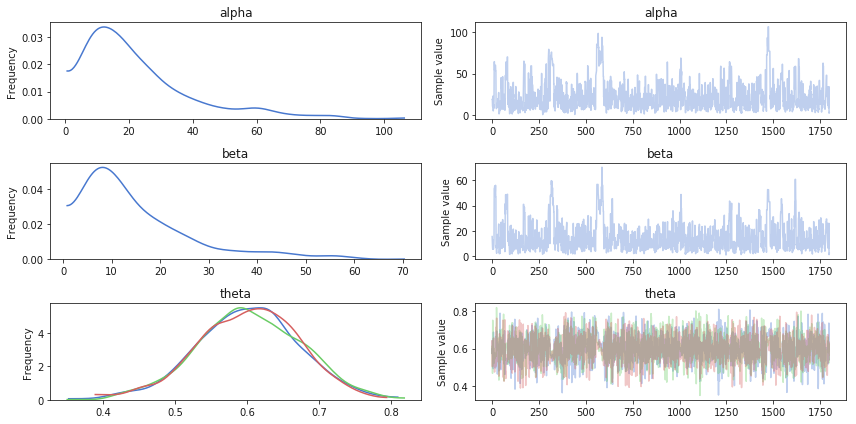

In [23]:
chain_h = trace_h[200:]
pm.traceplot(chain_h)


In [24]:
pm.df_summary(chain_h)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,23.14,17.56,1.15e+00,2.23,61.67
beta,15.35,11.66,7.62e-01,1.03,41.84
theta__0,0.60,0.07,2.16e-03,0.46,0.74
theta__1,0.60,0.07,2.37e-03,0.46,0.75
theta__2,0.60,0.07,1.82e-03,0.46,0.73


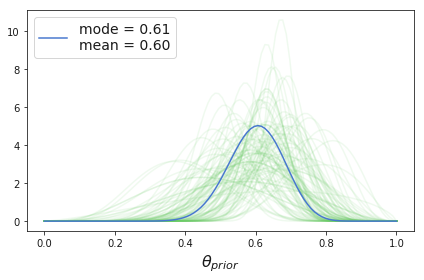

In [25]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(chain_h), size=100):
    pdf = stats.beta(chain_h['alpha'][i], chain_h['beta'][i]).pdf(x)
    plt.plot(x, pdf,  'g', alpha=0.1)

dist = stats.beta(chain_h['alpha'].mean(), chain_h['beta'].mean())
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, label='mode = {:.2f}\nmean = {:.2f}'.format(mode, mean))

plt.legend(fontsize=14)
plt.xlabel('$\\theta_{prior}$', fontsize=16)
plt.tight_layout()


In [26]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

This notebook was created on a x86_64 computer running Fedora 28 and using:
Python 3.6.3
IPython 6.1.0
PyMC3 3.2
NumPy 1.14.2
SciPy 1.0.0
Matplotlib 2.1.2
Seaborn 0.8.0
Pandas 0.22.0
